# Baseline Model Implementation 

### Google Drive Mounting for Datasets

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Using Mask RCNN

In [0]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from tqdm import tqdm_notebook
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Kaggle/train.csv')

In [0]:
data.shape

In [0]:
from glob import glob
train = '/content/gdrive/My Drive/Kaggle/train_images/'
test = '/content/gdrive/My Drive/Kaggle/test_images/'

train_name = sorted(glob(train+'*.jpg'))
test_name = sorted(glob(test+'*.jpg'))

print("{} images in train set".format(len(train_name)))
print("{} images in test set".format(len(test_name)))

12568 images in train set
5506 images in test set


<function matplotlib.pyplot.show>

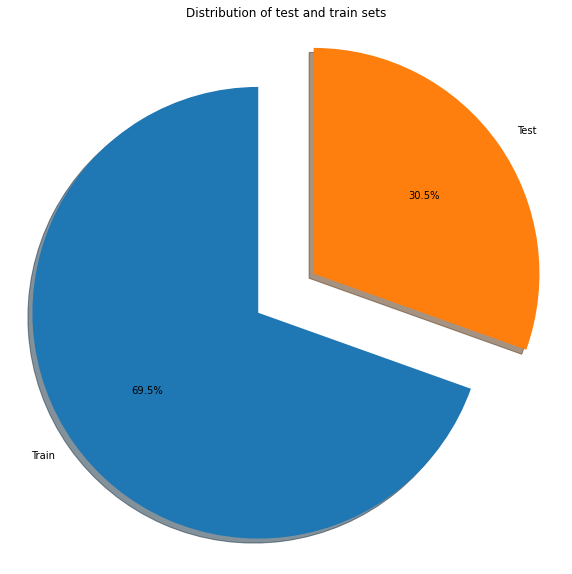

In [0]:
labels = 'Train','Test'
sizes = [len(train_name),len(test_name)]
explode = (0,0.3)

fig,ax = plt.subplots(figsize=(10,10))
ax.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis('equal')
ax.set_title("Distribution of test and train sets")
plt.show

In [0]:
print('Train info:')
print('1. Number of Data Points:',len(data))
print('2. Correct images:', data["EncodedPixels"].isna().sum().T)
print('3. Incorrect images',len(data)-data["EncodedPixels"].isna().sum().T)

Train info:
1. Number of Data Points: 7095
2. Correct images: 0
3. Incorrect images 7095


In [0]:
train_df_damaged = data[data["EncodedPixels"].notnull()]
train_df_damaged.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


Numeric info : 

1 class :  6239
2 classes :  425
3 classes :  2
4 classes :  0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


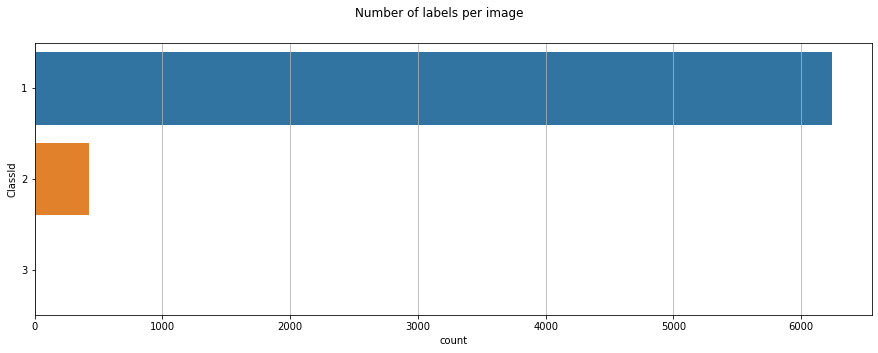

In [0]:
n_class_per_image =  train_df_damaged["ClassId"].groupby(train_df_damaged["ImageId"]).count()
plt.figure(figsize=(15,5))
plt.suptitle("Number of labels per image")
plt.grid()
import seaborn as sns
sns.countplot(y=n_class_per_image)
print("Numeric info : \n")
print("1 class : ",len(n_class_per_image[n_class_per_image == 1]))
print("2 classes : ",len(n_class_per_image[n_class_per_image == 2]))
print("3 classes : ",len(n_class_per_image[n_class_per_image == 3]))
print("4 classes : ",len(n_class_per_image[n_class_per_image == 4]))

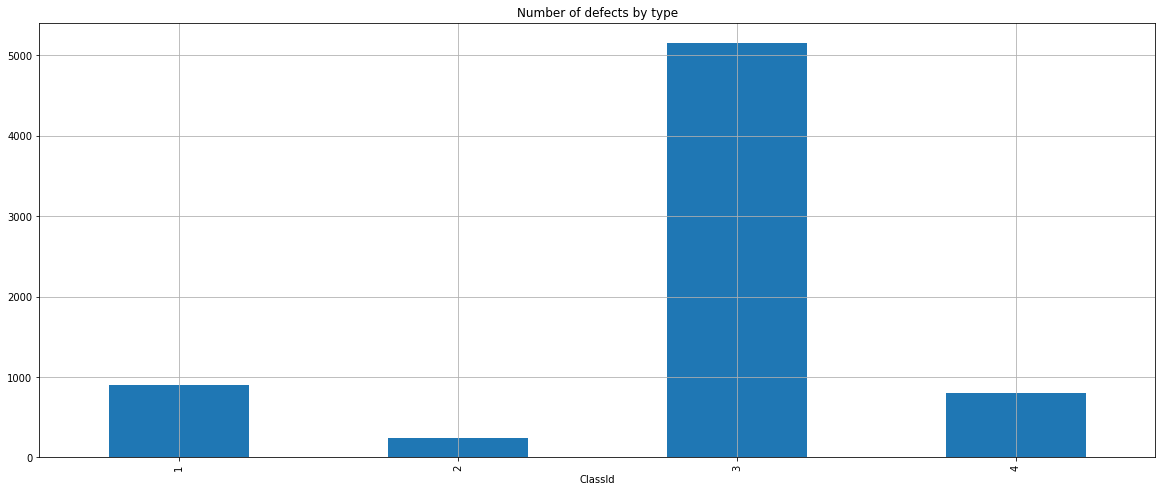

In [0]:
data.groupby('ClassId')['EncodedPixels'].count().plot(kind='bar',
                                                            title='Number of defects by type', 
                                                            figsize=(20, 8),
                                                            grid=True);

In [0]:
train = pd.DataFrame({'ImageId':data['ImageId'][0::4]})
train_data = train.iloc[:int(0.80*len(train))]
test_data = train.iloc[int(0.80*len(train)):int(0.9*len(train))]
cv_data = train.iloc[int(0.9*len(train)):]

In [0]:
data['ImageId'] = data['ImageId'].map(lambda x : x.split(".")[0]+'.jpg') # This will take id after interval of 4 rows.
train = pd.DataFrame({'ImageId':data['ImageId'][0::4]}) # Creating dataframe with image names of images
train['k1'] = data['EncodedPixels'][0::4].values # Will take encoding after interval of 4.
train['k2'] = data['EncodedPixels'][1::4].values
train['k3'] = data['EncodedPixels'][2::4].values
#train['e4'] = data['EncodedPixels'][3::4].values
train.reset_index(inplace=True, drop=True)
train.fillna('', inplace=True)
train.head()

,ImageId,k1,k2,k3
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,18661 28 18863 82 19091 110 19347 110 19603 11...,37607 3 37858 8 38108 14 38359 20 38610 25 388...
1,0014fce06.jpg,229501 11 229741 33 229981 55 230221 77 230468...,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,186833 1 187089 3 187344 6 187600 7 187855 10 ...
3,005d86c25.jpg,331 18 587 53 843 89 1099 124 1355 159 1611 17...,318652 8 318863 6 318903 17 319114 15 319158 2...,123137 7 123393 19 123649 32 123905 44 124161 ...
4,0088260da.jpg,26044 13 26283 40 26522 67 26762 92 27001 119 ...,72425 21 72641 61 72856 102 73071 142 73287 18...,356336 4 356587 11 356838 18 357089 25 357340 ...


In [0]:
print(train_data.shape)
print(test_data.shape)
print(cv_data.shape)

(1419, 1)
(177, 1)
(178, 1)


In [0]:
def rle2mask(rle):
  # If rle is empty or null
  if(len(rle)<1): 
    return np.zeros((128,800) ,dtype=np.uint8)
    
  height = 256
  width = 1600
  
  # Defining the length of mask. This will be 1d array and later will be reshaped to 2d.
  mask = np.zeros(height*width ).astype(np.uint8)
  # We will have an array that wil contain rle
  array = np.asarray([int(x) for x in rle.split()])
  start = array[0::2]-1 # this willl contain the start of run length
  length = array[1::2] # this will contain the length of each rle.

  for i,start in enumerate(start):
    mask[int(start):int(start+length[i])] = 1
    return mask.reshape( (height,width), order='F' )[::2,::2]

In [0]:
def mask2rle(img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        #print(img.shape)
        pixels= img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = data
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = '/content/gdrive/My Drive/Kaggle/' + 'train_images/'
        elif self.subset == "test":
            self.data_path = '/content/gdrive/My Drive/Kaggle/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and samplewise std normalization
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            if self.subset == 'train': 
                #run-length encoding on the pixel values
                for j in range(3):
                    mask = rle2mask(self.df['ClassId'])
                    y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [0]:
from keras import backend as K
from keras.losses import binary_crossentropy
# Competetion Metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def  bce_dice_loss(y_true, y_predict):
  return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

In [0]:
inputs = Input((128,800,3)) # 256
down = Conv2D(32, (3, 3), padding='same')(inputs)
down = BatchNormalization()(down)
down = Activation('relu')(down)
down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down) #128
center = Conv2D(128, (3, 3), padding='same')(down_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center) # center
up = UpSampling2D((2, 2))(center)
up = concatenate([down, up], axis=3)
up = Conv2D(32, (3, 3), padding='same')(up)
up = BatchNormalization()(up)
up = Activation('relu')(up) # 256
classify = Conv2D(4, (1, 1), activation='sigmoid')(up)
model = Model(inputs=inputs, outputs=classify)
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy',dice_coef])

In [0]:
train_batches = DataGenerator(train_data,shuffle=True)
valid_batches = DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1)

Epoch 1/20


KeyError: ignored